# 门控循环单元 GRU
我们讨论了如何在循环神经⽹络中计算梯度，以及矩阵连续乘积可以导致梯度消失或梯度爆炸的问题。下⾯我们简单思考⼀下这种梯度异常在实践中的意义：
+ 我们可能会遇到这样的情况：早期观测值对预测所有未来观测值具有⾮常重要的意义。考虑⼀个极端情况，其中第⼀个观测值包含⼀个校验和，⽬标是在序列的末尾辨别校验和是否正确。在这种情况下，第⼀个词元的影响⾄关重要。我们希望有某些机制能够在⼀个记忆元⾥存储重要的早期信息。如果没有这样的机制，我们将不得不给这个观测值指定⼀个⾮常⼤的梯度，因为它会影响所有后续的观测值。
+ 我们可能会遇到这样的情况：⼀些词元没有相关的观测值。例如，在对⽹⻚内容进⾏情感分析时，可能有⼀些辅助HTML代码与⽹⻚传达的情绪⽆关。我们希望有⼀些机制来跳过隐状态表⽰中的此类词元。
+ 我们可能会遇到这样的情况：序列的各个部分之间存在逻辑中断。例如，书的章节之间可能会有过渡存在，或者证券的熊市和⽜市之间可能会有过渡存在。在这种情况下，最好有⼀种⽅法来重置我们的内部状态表⽰。

## 1. 门控隐状态
⻔控循环单元与普通的循环神经⽹络之间的关键区别在于：前者⽀持隐状态的⻔控。这意味着模型有专⻔的
机制来确定应该何时更新隐状态，以及应该何时重置隐状态。这些机制是可学习的，并且能够解决了上⾯列
出的问题。例如，如果第⼀个词元⾮常重要，模型将学会在第⼀次观测之后不更新隐状态。同样，模型也可以
学会跳过不相关的临时观测。最后，模型还将学会在需要的时候重置隐状态。下⾯我们将详细讨论各类⻔控。

+ 重置门和更新门


我们⾸先介绍重置⻔（reset gate）和更新⻔（update gate）。我们把它们设计成(0, 1)区间中的向量，这样我们就可以进⾏凸组合。重置⻔允许我们控制“可能还想记住”的过去状态的数量；更新⻔将允许我们控制新状态中有多少个是旧状态的副本。了⻔控循环单元中的重置⻔和更新⻔的输⼊，输⼊是由当前时间步的输⼊和前⼀时间步的隐状态给出。两个⻔的输出是由使sigmoid激活函数的两个全连接层给出。
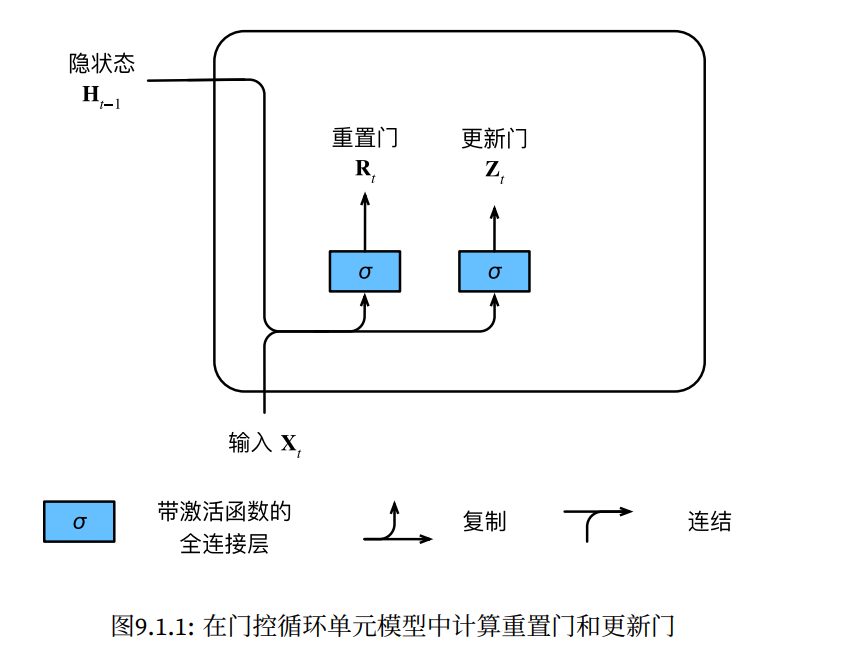
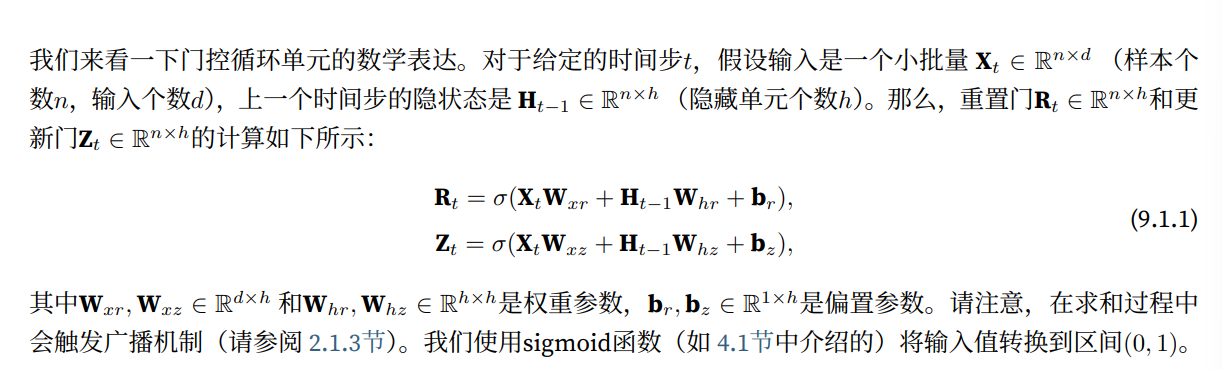


+ 候选隐状态-Reset Gate

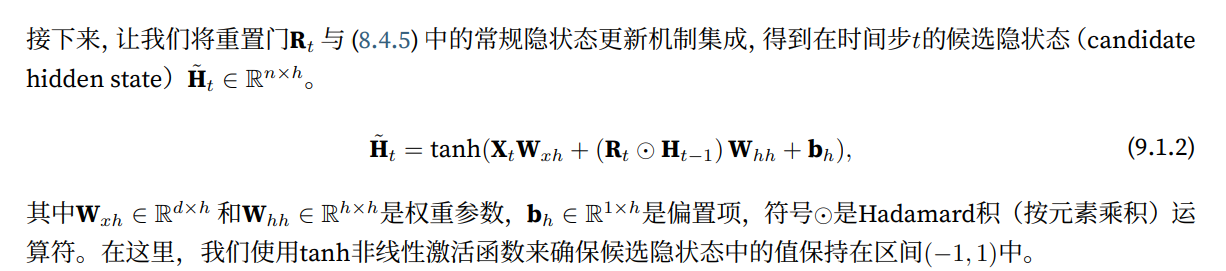
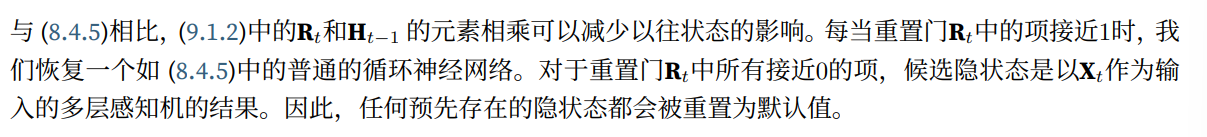
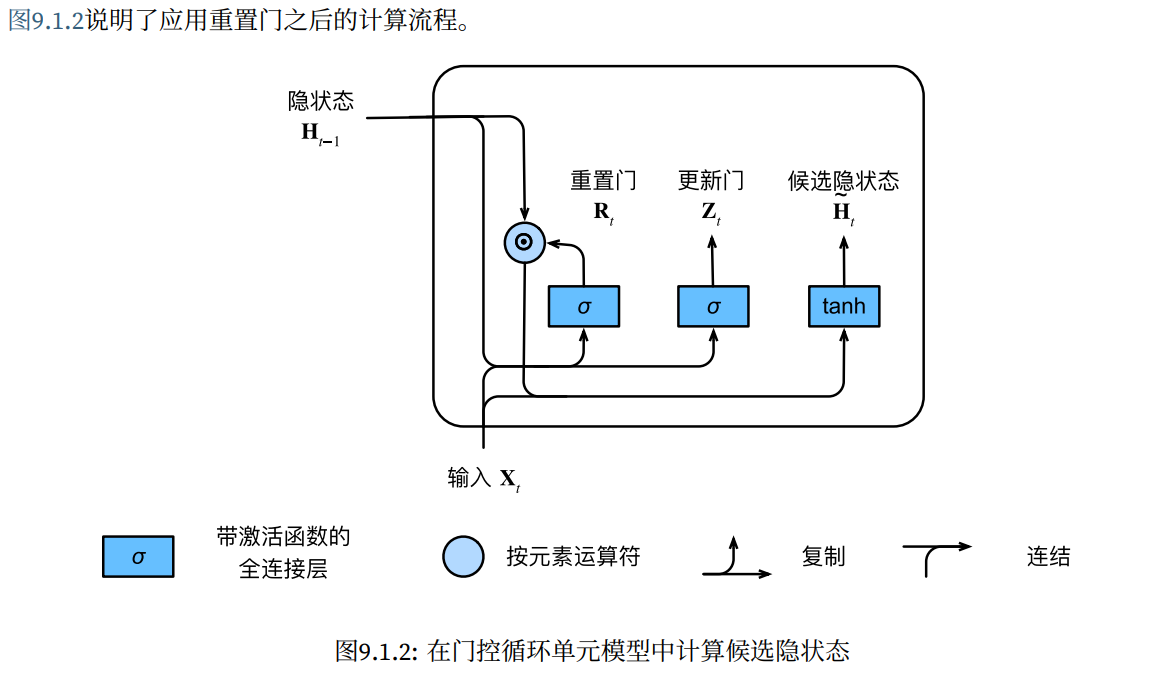

+ 隐状态-Update Gate
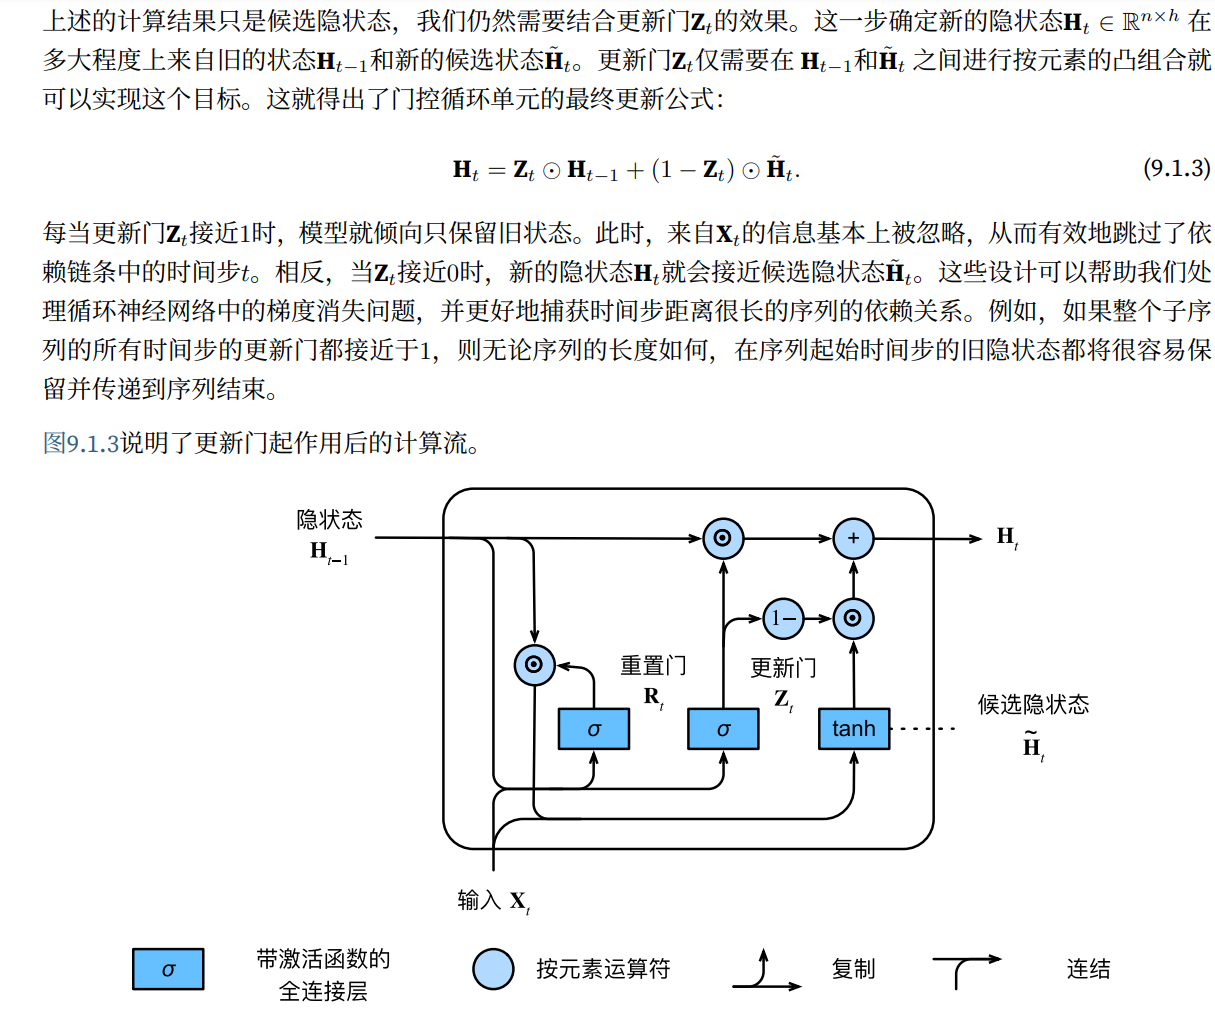

+ 总之，⻔控循环单元具有以下两个显著特征：
    + 重置⻔有助于捕获序列中的短期依赖关系；
    + 更新⻔有助于捕获序列中的⻓期依赖关系。


## 2. 从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

+ 初始化模型参数

下⼀步是初始化模型参数。我们从标准差为0.01的⾼斯分布中提取权重，并将偏置项设为0，超参数num_hiddens定义隐藏单元的数量，实例化与更新⻔、重置⻔、候选隐状态和输出层相关的所有权重和
偏置。


In [2]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.1
    
    def three():
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    
    # 隐藏层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 给参数添加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

+ 定义模型

In [3]:
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [4]:
# 现在我们准备定义⻔控循环单元模型，模型的架构与基本的循环神经⽹络单元是相同的，只是权重更新公式更为复杂。
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda # 更新
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

+ 训练与预测

perplexity 1.0, 14847.2 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


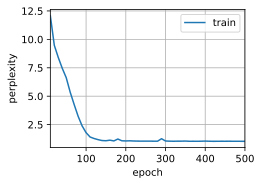

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                           init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 3. 简介实现

perplexity 1.0, 17823.4 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


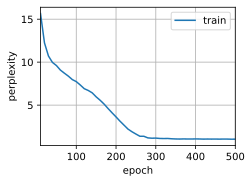

In [8]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)